# Linear increasing price

In [1]:
# imports
import numpy as np
np.random.seed(11)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
import backtest as twp
from matplotlib import pyplot as plt

from sklearn import metrics, preprocessing

In [2]:
#Load data
def load_data(type_evol='linear'):
    if type_evol == 'linear':
        price = np.arange(200/10.0) #linearly increasing prices
    elif type_evol == 'sin':
        price = np.sin(np.arange(200)/30.0) #sine prices 
    return price

In [3]:
#Initialize first state, all items are placed deterministically
def init_state(data):
    
    close = data
    diff = np.diff(data)
    diff = np.insert(diff, 0, 0)
    
    #--- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    
    state = xdata[0:1, :]
    return state, xdata

In [4]:
#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step, :]
        terminal_state = 1
        signal.loc[time_step] = 0
        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, :]
    #take action
    if action != 0:
        if action == 1:
            signal.loc[time_step] = 100
        elif action == 2:
            signal.loc[time_step] = -100
        elif action == 3:
            signal.loc[time_step] = 0
    terminal_state = 0

    return state, time_step, signal, terminal_state

In [5]:
#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        #get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
                i += 1
            reward = (xdata[time_step-1, 0] - xdata[time_step - i-1, 0]) * signal[time_step - 1]*-100 + i*np.abs(signal[time_step - 1])/10.0
        if signal[time_step] == 0 and signal[time_step - 1] == 0:
            reward -= 10

    #calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        #run backtest, send list of trade signals and asset data to backtest function
        bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward

In [6]:
def evaluate_Q(eval_data, eval_model):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    return eval_reward

In [7]:
#This neural network is the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, kernel_initializer='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

In [8]:
import random, timeit

start_time = timeit.default_timer()

indata = load_data(type_evol='sin')
epochs = 50
gamma = 0.9 #a high gamma makes a long-term reward more valuable
epsilon = 1
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0
signal = pd.Series(index=np.arange(len(indata)))
for i in range(epochs):

    state, xdata = init_state(indata)
    status = 1
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #maybe choose random action if not the last epoch
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if terminal_state == 0: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state (means that it is the last state)
            update = reward
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, epochs=1, verbose=0)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    eval_reward = evaluate_Q(indata, model)
    print("Epoch #: %s Reward: %f Epsilon: %f" % (i,eval_reward, epsilon))
    learning_progress.append((eval_reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

1/1 [==============================] - 0s 8ms/step
Epoch #: 0 Reward: -29.671610 Epsilon: 1.000000
1/1 [==============================] - 0s 12ms/step
Epoch #: 1 Reward: -228.934570 Epsilon: 0.980000
1/1 [==============================] - 0s 7ms/step
Epoch #: 2 Reward: -79.981956 Epsilon: 0.960000
1/1 [==============================] - 0s 7ms/step
Epoch #: 3 Reward: -211.866480 Epsilon: 0.940000
1/1 [==============================] - 0s 8ms/step
Epoch #: 4 Reward: 64.483446 Epsilon: 0.920000
1/1 [==============================] - 0s 8ms/step
Epoch #: 5 Reward: -10.661262 Epsilon: 0.900000
1/1 [==============================] - 0s 7ms/step
Epoch #: 6 Reward: 54.548267 Epsilon: 0.880000
1/1 [==============================] - 0s 8ms/step
Epoch #: 7 Reward: 192.397136 Epsilon: 0.860000
1/1 [==============================] - 0s 8ms/step
Epoch #: 8 Reward: 224.095336 Epsilon: 0.840000
1/1 [==============================] - 0s 6ms/step
Epoch #: 9 Reward: 234.400708 Epsilon: 0.820000
1/1 [====

        price  shares      value        cash         pnl  delta
0   -0.014472     0.0  -0.000000    0.000000    0.000000    0.0
1    0.033959     0.0   0.000000    0.000000    0.000000    0.0
2    0.082336   100.0   8.233615   -8.233615    0.000000  100.0
3    0.130606   100.0  13.060554   -8.233615    4.826939    0.0
4    0.178714   100.0  17.871375   -8.233615    9.637760    0.0
..        ...     ...        ...         ...         ...    ...
195  0.298139   100.0  29.813903  279.372311  309.186213    0.0
196  0.345262   100.0  34.526224  279.372311  313.898535    0.0
197  0.391986   100.0  39.198579  279.372311  318.570890    0.0
198  0.438258   100.0  43.825776  279.372311  323.198087    0.0
199  0.484027   100.0  48.402675  279.372311  327.774986    0.0

[200 rows x 6 columns]


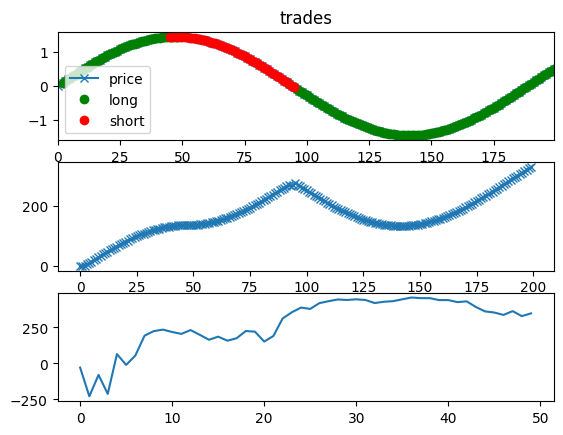

In [9]:
#plot results
bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
# plt.savefig('plt/final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) #assumes there is a ./plt dir
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.show()